In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime,timedelta
mta_data = pd.read_pickle('mta_data.pickle')

In [2]:
#reset index and drop old indices to remove duplicate indexes and fix cols; remove duplicates
mta_data = mta_data.reset_index().drop('index',axis=1)
mta_data.columns = [col.strip() for col in mta_data.columns]
mta_data.drop_duplicates(subset = ['C/A','UNIT','SCP','LINENAME','DIVISION','DATE','TIME'],inplace=True)

In [3]:
# convert dates to datetime, create col; convert that to day of week, create col; convert that to weekday T/F, create col
mta_data['weekday'] = pd.to_datetime(mta_data.DATE,format='%m/%d/%Y')
mta_data['weekday_n'] = mta_data.weekday.dt.dayofweek
mta_data['weekday_tf'] = mta_data.weekday_n<5

In [4]:
#create columns for entries since last time
mta_data['peop_in'] = mta_data.groupby(['weekday','SCP'])['ENTRIES'].diff(periods = 1)
mta_data['peop_out'] = mta_data.groupby(['weekday','SCP'])['EXITS'].diff(periods = 1)

In [5]:
mta_data.groupby('TIME').size().nlargest(n=18)
#seems that there are 3 big groups - 0/4/8/12/16/20 ; 1/5/9/13/17/21 ; 3/7/11/15/19/23
#maybe filter from 4-19? cuts 2 from each group at non-working hours

TIME
04:00:00    846407
08:00:00    846090
20:00:00    845772
16:00:00    845721
12:00:00    845546
00:00:00    844337
05:00:00    551138
17:00:00    550683
21:00:00    550683
09:00:00    550659
13:00:00    550439
01:00:00    546199
03:00:00    121098
07:00:00    120987
15:00:00    120962
19:00:00    120961
11:00:00    120927
23:00:00    120923
dtype: int64

In [6]:
#these times capture 90% of the data - cool!
mta_data.groupby('TIME').size().nlargest(n=18).sum()/mta_data.groupby('TIME').size().sum()

0.8922675646020233

In [7]:
#get dates w time so that we can filter for certain times
mta_data['time']=pd.to_datetime(mta_data.TIME,format='%H:%M:%S')

In [8]:
#where are out nas
mta_data[mta_data.peop_in.isna()]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,weekday,weekday_n,weekday_tf,peop_in,peop_out,time
0,A002,R051,02-00-00,59 ST,NQR456,BMT,02/27/2016,03:00:00,REGULAR,5562172,1877574,2016-02-27,5,False,NaN,NaN,1900-01-01 03:00:00
6,A002,R051,02-00-00,59 ST,NQR456,BMT,02/28/2016,03:00:00,REGULAR,5563262,1877882,2016-02-28,6,False,NaN,NaN,1900-01-01 03:00:00
12,A002,R051,02-00-00,59 ST,NQR456,BMT,02/29/2016,03:00:00,REGULAR,5564033,1878126,2016-02-29,0,True,NaN,NaN,1900-01-01 03:00:00
19,A002,R051,02-00-00,59 ST,NQR456,BMT,03/01/2016,03:00:00,REGULAR,5565799,1878725,2016-03-01,1,True,NaN,NaN,1900-01-01 03:00:00
26,A002,R051,02-00-00,59 ST,NQR456,BMT,03/02/2016,03:00:00,REGULAR,5567572,1879378,2016-03-02,2,True,NaN,NaN,1900-01-01 03:00:00
32,A002,R051,02-00-00,59 ST,NQR456,BMT,03/03/2016,03:00:00,REGULAR,5569303,1880004,2016-03-03,3,True,NaN,NaN,1900-01-01 03:00:00
38,A002,R051,02-00-00,59 ST,NQR456,BMT,03/04/2016,03:00:00,REGULAR,5571113,1880626,2016-03-04,4,True,NaN,NaN,1900-01-01 03:00:00
45,A002,R051,02-00-01,59 ST,NQR456,BMT,02/27/2016,03:00:00,REGULAR,5114878,1116740,2016-02-27,5,False,NaN,NaN,1900-01-01 03:00:00
51,A002,R051,02-00-01,59 ST,NQR456,BMT,02/28/2016,03:00:00,REGULAR,5115864,1116969,2016-02-28,6,False,NaN,NaN,1900-01-01 03:00:00
57,A002,R051,02-00-01,59 ST,NQR456,BMT,02/29/2016,03:00:00,REGULAR,5116530,1117111,2016-02-29,0,True,NaN,NaN,1900-01-01 03:00:00


In [9]:
#filter for 4-7 (could do 3-9 but less working time)
mta_data = mta_data.set_index('time').between_time('04:00:00','19:00:00').reset_index()

In [10]:
#we don't want to drop where peop_in/peop_out = 0 - this could be an error or a broken machine, but we don't actually 
#know that, and zeros matter for average
#mta_data = mta_data[mta_data.peop_in!=0]
#mta_data = mta_data[mta_data.peop_out!=0]
#tt[tt.peop_in.isna()]

In [11]:
#make backwards ticker go forward!
mta_data['peop_in'] = abs(mta_data.peop_in)
mta_data['peop_out'] = abs(mta_data.peop_out)

#let's assume we have the best volunteer ever!
#even if they get 3 emails a minutes, they can only get 720 emails per 4 hour period
#so lets limit both people in and out to 720!
mta_data.peop_out[mta_data['peop_out']>720] = 720
mta_data.peop_in[mta_data['peop_in']>720] = 720


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [12]:
mta_data = mta_data.dropna()

In [13]:
#time_try.groupby('time').size().sum()/mta_data.groupby('time').size().sum()
#so hey! this was initially comparing a table that we had cleaned that was not the mta_data table
#... but then we wanted to clean our actual table
# so as a note : the result of this was ~66%
# oh no! only 66%?
# nope! that makes sense -  we filtered out about 1/3 of the times for the biggest part of our data

In [14]:
### here we want to remove crazy big numbers and make negatives positive

In [15]:
#find sum of data and the total number of people through by day
sum_d = mta_data.groupby(['STATION','weekday']).sum()
sum_d['through']=sum_d.peop_in+sum_d.peop_out
sum_d.reset_index(inplace=True)

In [16]:
#Create new row in order to fix issue with adding t/f values and calculate dif in mean on weekday v weekend
sum_d['weekend_tf'] = sum_d.weekday_tf == 0
sum_d_m = sum_d.groupby(['STATION','weekend_tf']).mean()
sum_d_m.reset_index(inplace=True)
sum_d_m['mean_dif']=sum_d_m.groupby("STATION").diff(periods=1).through

In [17]:
#select only 1 value for each, because diff is unreliable
mean_difs = sum_d_m[sum_d_m.weekend_tf == True]

In [18]:
#remove NA and find 10 worst stations (more traffic on weekend=touristy)
top10b = mean_difs.sort_values(by='mean_dif').head(10)

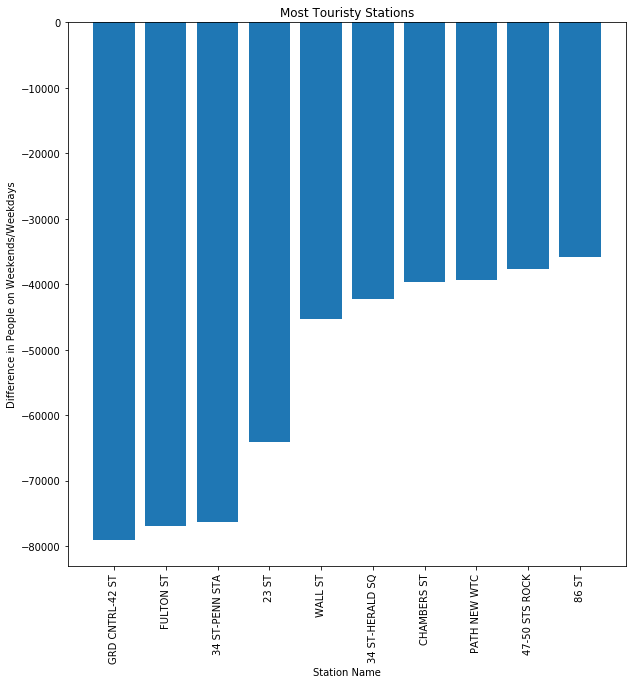

In [19]:
#plot those 10
plt.figure(figsize=(10,10))
plt.bar(x=top10b.STATION,height=top10b.mean_dif)
plt.xticks(rotation=90)
plt.title('Most Touristy Stations')
plt.xlabel('Station Name')
plt.ylabel('Difference in People on Weekends/Weekdays')
plt.show();

In [20]:
#remove NA and find 10 best stations (more traddic on weekdays = commuter)
top10g = mean_difs.sort_values(by='mean_dif',ascending=False).head(10)

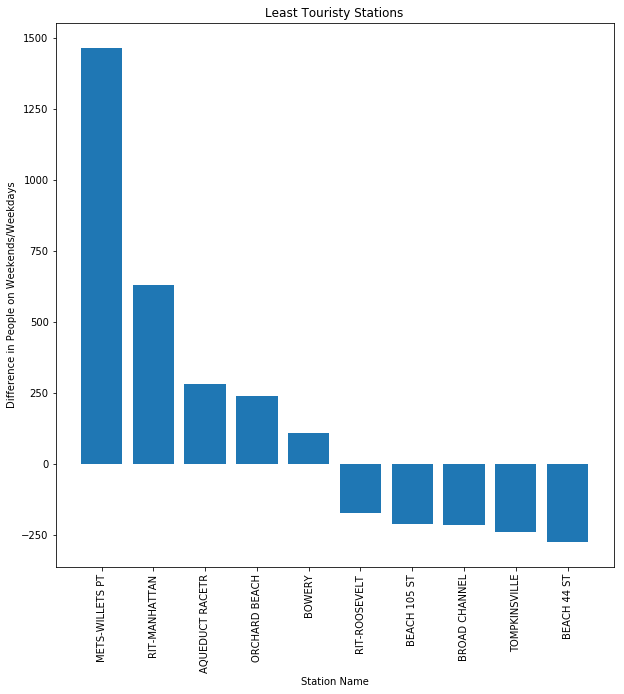

In [21]:
#plot those 10
plt.figure(figsize=(10,10))
plt.bar(x=top10g.STATION,height=top10g.mean_dif)
plt.xticks(rotation=90)
plt.title('Least Touristy Stations')
plt.xlabel('Station Name')
plt.ylabel('Difference in People on Weekends/Weekdays')
plt.show();

In [22]:
# new table w sum of each day through, lose unimportant cols
tourist_ratio = sum_d
tourist_ratio = sum_d.drop(['ENTRIES','EXITS','weekday_n','weekday_tf','peop_in','peop_out'],axis=1)

In [23]:
#find mean through based on station and weekendness
tourist_ratio = tourist_ratio.sort_values('weekend_tf').groupby(['STATION','weekend_tf']).mean()
#pct in every other row shows %dif in weekend traffic from weekday traffic
#if fewer on weekend, then that will mean a negative score (-.33); so neg is better
tourist_ratio['ratio']=tourist_ratio.through.pct_change()

In [24]:
tourist_ratio.reset_index(inplace=True)

In [25]:
#choose only weekend days (where the percent was meaningful)
ratio_table = tourist_ratio[tourist_ratio.weekend_tf==True]
ratio_table.reset_index(inplace=True)
#prepare for joining
ratio_table.set_index('STATION',inplace=True)
ratio_table.drop(['weekend_tf','through'],axis=1,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [26]:
#sums of daily traffic by station and weekdayness again; find weekdays
station_ratio_through = mta_data.groupby(['STATION','weekday_tf']).sum()[1::2]

In [27]:
station_ratio_through.reset_index(inplace=True)

In [28]:
#preparing for later joining by setting index
station_ratio_through = station_ratio_through.set_index("STATION").join(ratio_table)

In [29]:
#divide through to prevent scientific notation/dumb scores
station_ratio_through['through'] = (station_ratio_through.peop_in+station_ratio_through.peop_out)/10000000

In [30]:
#filter out stations with less than 1 million people daily
station_ratio_through = station_ratio_through[station_ratio_through.through>.1]

In [31]:
#weighted score formula
station_ratio_through['score'] = .7 * station_ratio_through.ratio - .3 * station_ratio_through.through

In [32]:
#top 20 list!
top20_rt = station_ratio_through.sort_values(by='score').head(20)
top20_rt.score = top20_rt.score*-1

In [33]:
top20_rt.reset_index(inplace=True)

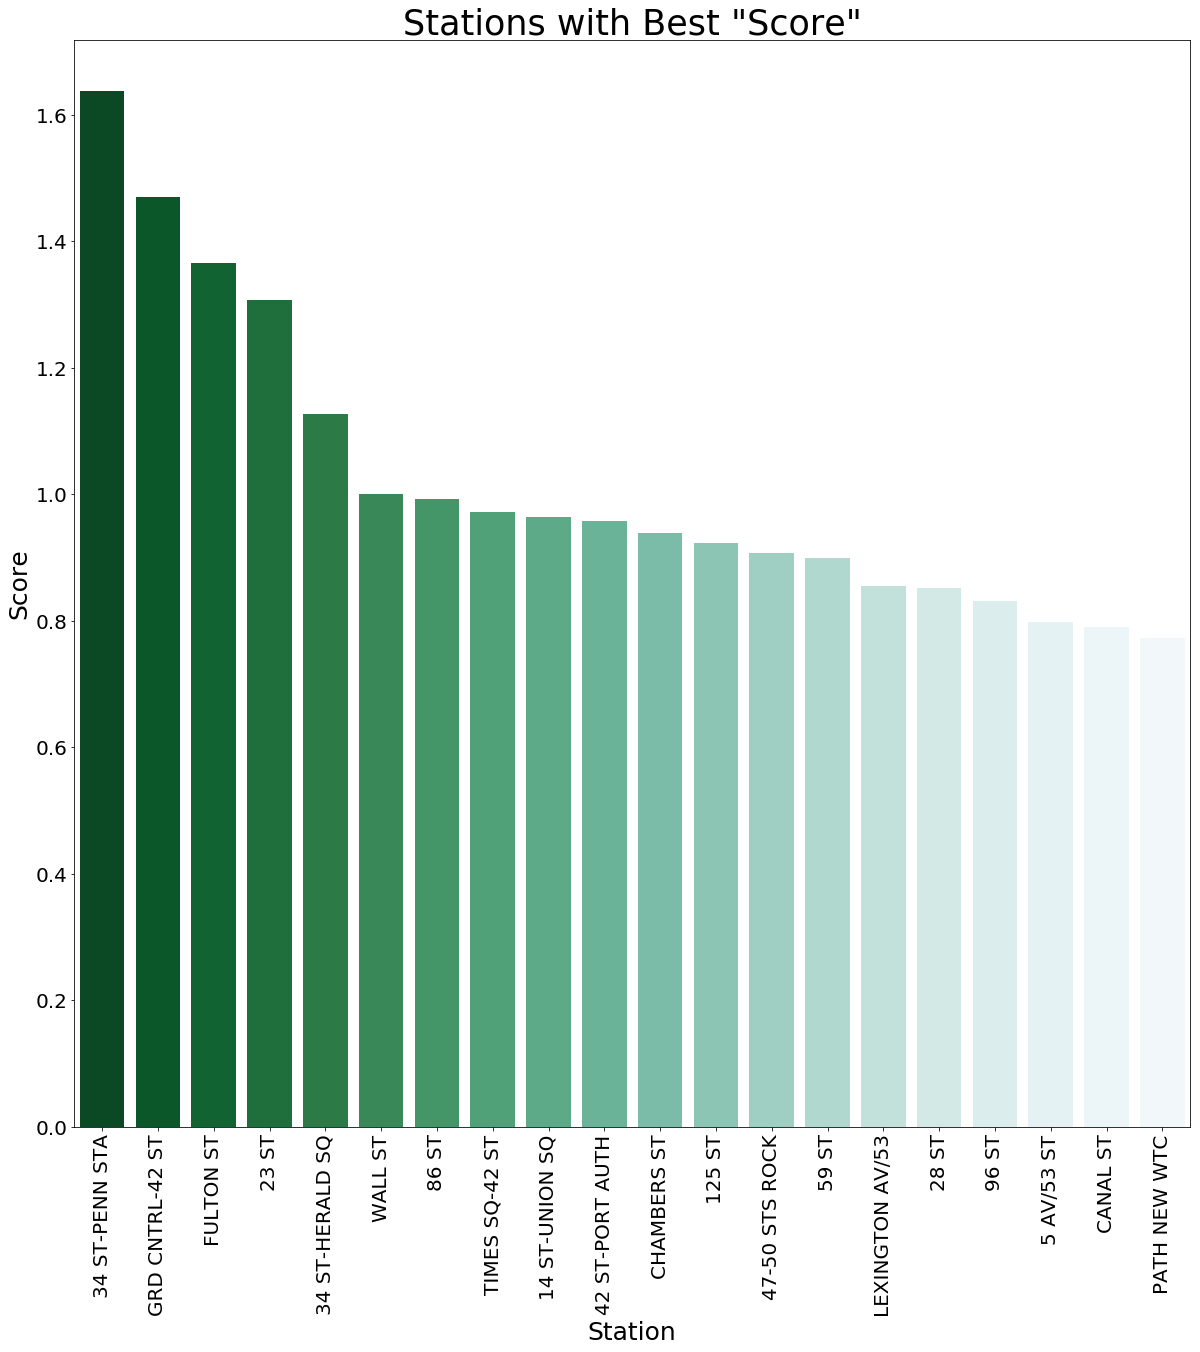

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure (figsize=(20,20))
plt.title('Stations with Best "Score"',fontsize=35)
sns.barplot(x='STATION', y='score', data = top20_rt, palette = sns.color_palette('BuGn_r',n_colors = 20))
plt.xticks(rotation=90,fontsize=20)
plt.xlabel('Station',fontsize=25)
plt.yticks(fontsize = 20)
plt.ylabel('Score',fontsize = 25)
plt.savefig("resize.svg", format="svg");

In [35]:
bottom20_rt = station_ratio_through.sort_values(by='score',ascending=False).head(20)

In [36]:
bottom20_rt.reset_index(inplace = True)

In [37]:
bottom20_rt['score'] = bottom20_rt.score*-1

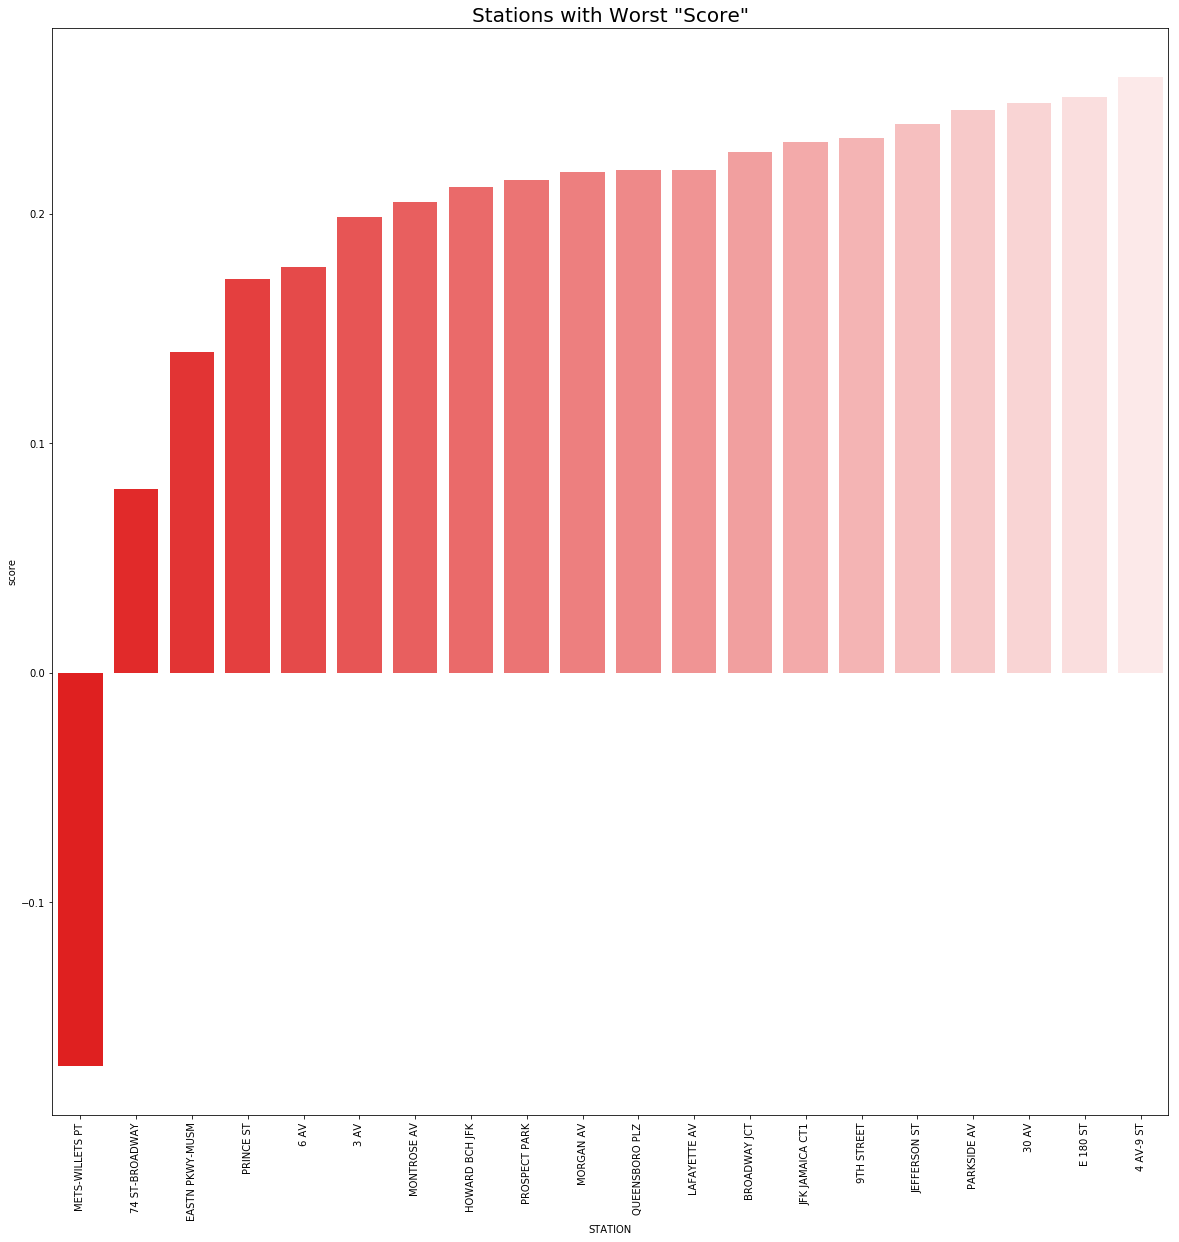

In [38]:
plt.figure (figsize=(20,20))
plt.xticks(rotation=90)
plt.title('Stations with Worst "Score"',fontsize = 20)
sns.barplot(x='STATION', y='score', data = bottom20_rt,palette = sns.light_palette('red',n_colors = 20,reverse=True))

In [39]:
#now with distance data!
dist = pd.read_pickle('tech_station.pickle')

In [40]:
#set correct index for merge
dist.rename(columns = {'Station':'STATION'},inplace=True)

In [41]:
#merging the tables
station_rtd = pd.merge(station_ratio_through,dist,on='STATION')
station_rtd.head()

,STATION,weekday_tf,ENTRIES,EXITS,weekday_n,peop_in,peop_out,index,ratio,through,score,Tech_Station
0,1 AV,True,2144966071934,2160030616927,20964,2723162.0,3195317.0,1,-0.252186,0.591848,-0.354085,1
1,103 ST,True,156882378770,624223355853,31050,5641991.0,2921980.0,3,-0.444476,0.856397,-0.568052,0
2,103 ST-CORONA,True,69711781783,67922071906,19132,3746883.0,1539256.0,5,-0.275793,0.528614,-0.351639,0
3,104 ST,True,4654762345244,3510819271092,18581,941750.0,180567.0,7,-0.529284,0.112232,-0.404168,0
4,110 ST,True,32663176626,32861134392,12805,2114764.0,1430486.0,9,-0.395920,0.354525,-0.383501,0


In [42]:
#defining 
station_rtd['score'] = .6*station_rtd.ratio - .1*station_rtd.through - .3 * station_rtd.Tech_Station

In [43]:
bottom_20 = station_rtd.sort_values(by='score',ascending=False).head(20)

In [44]:
top_20 = station_rtd.sort_values(by='score').head(20)

In [45]:
top_20.score = top_20.score*-1

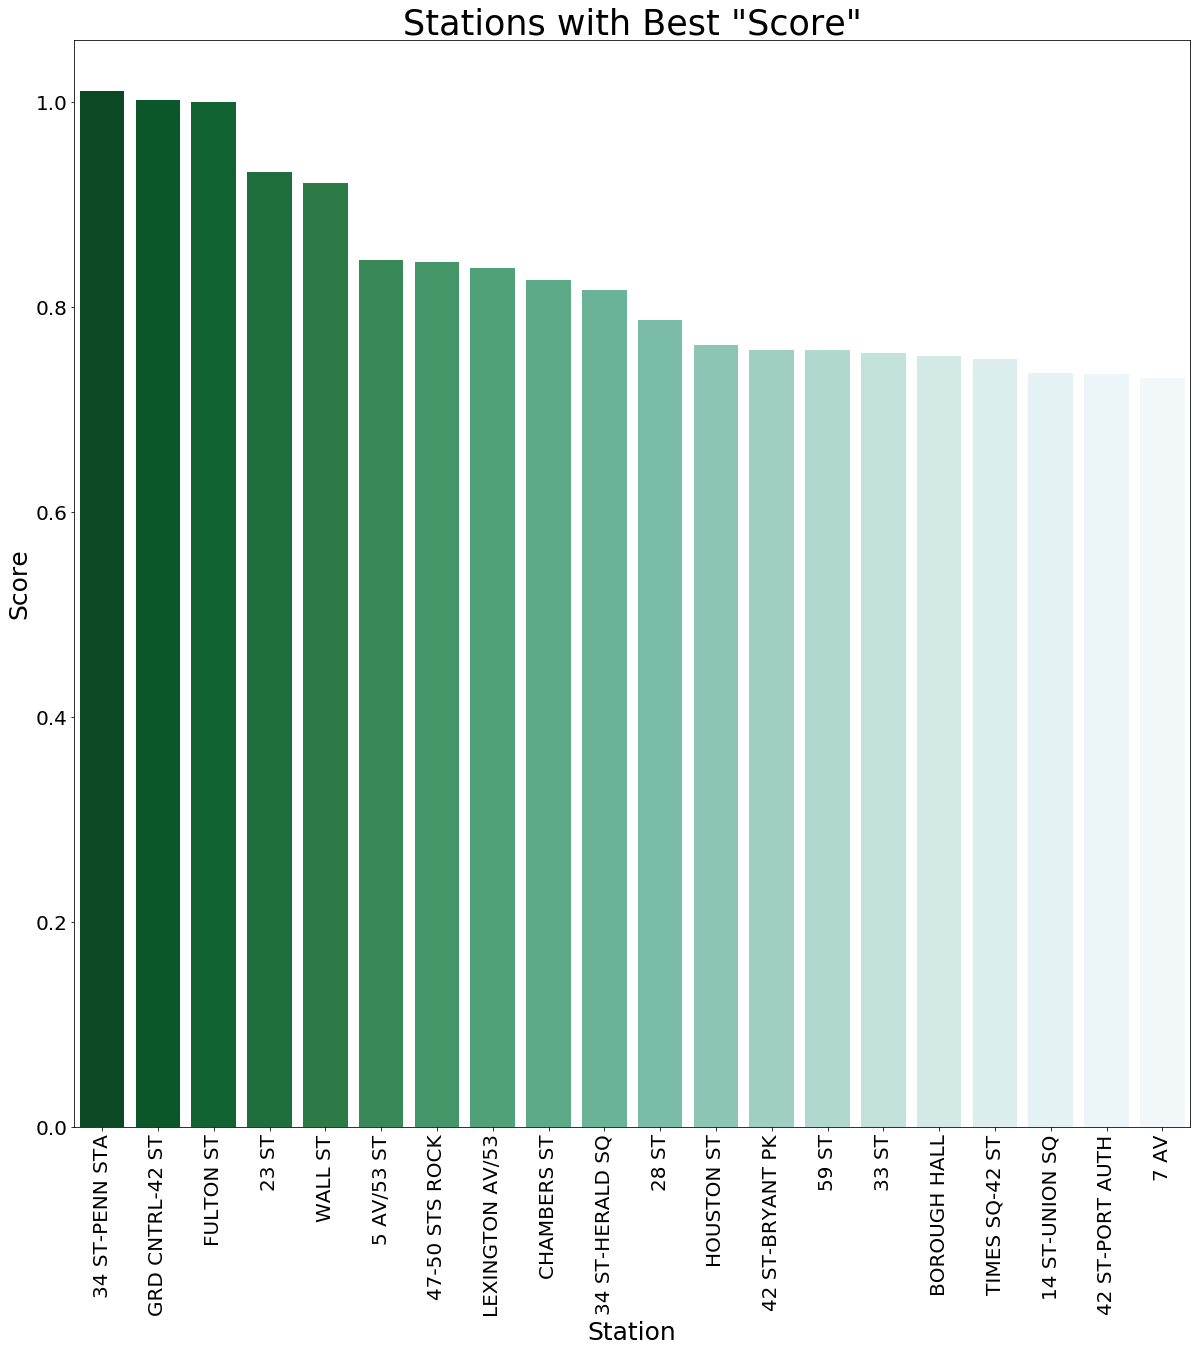

In [46]:
plt.figure (figsize=(20,20))
plt.xticks(rotation=90)
plt.title('Stations with Best "Score"',fontsize = 35)
sns.barplot(x='STATION', y='score', data = top_20, palette = sns.color_palette('BuGn_r',n_colors = 20))
plt.xticks(rotation=90,fontsize=20)
plt.xlabel('Station',fontsize=25)
plt.yticks(fontsize = 20)
plt.ylabel('Score',fontsize = 25)
plt.savefig('final_t_20.svg',format='svg');

In [47]:
bottom_20.score = bottom_20.score*-1

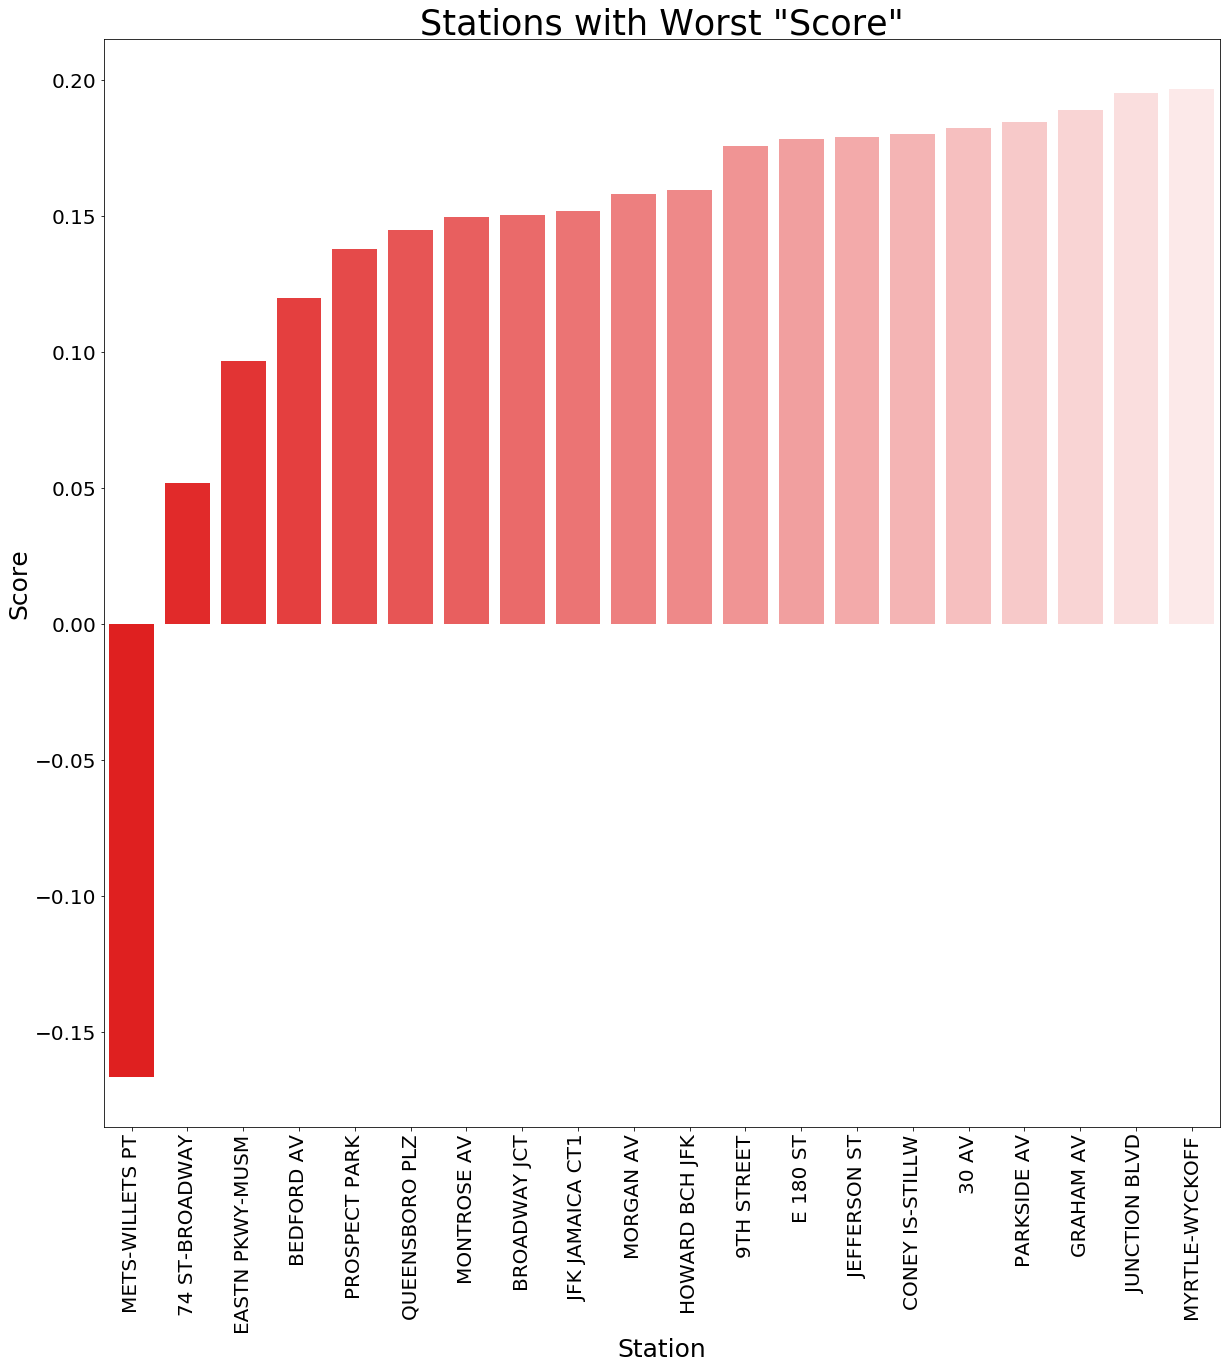

In [48]:
plt.figure (figsize=(20,20))
plt.xticks(rotation=90)
plt.title('Stations with Worst "Score"',fontsize = 35)
sns.barplot(x='STATION', y='score', data = bottom_20,palette = sns.light_palette('red',n_colors = 20,reverse=True))
plt.xticks(rotation=90,fontsize=20)
plt.xlabel('Station',fontsize=25)
plt.yticks(fontsize = 20)
plt.ylabel('Score',fontsize = 25)
plt.savefig('final_b_20.svg',format='svg');

In [51]:
top_20

,STATION,weekday_tf,ENTRIES,EXITS,weekday_n,peop_in,peop_out,index,ratio,through,score,Tech_Station
56,34 ST-PENN STA,True,3808358061887,2354162809249,210330,24524558.0,19535063.0,123,-0.449978,4.405962,1.010583,1
195,GRD CNTRL-42 ST,True,3097783638270,1740956710379,134070,16641419.0,18866332.0,467,-0.579067,3.550775,1.002518,1
188,FULTON ST,True,4352877572044,4480886683635,201952,14486950.0,15370106.0,453,-0.670123,2.985706,1.000644,1
42,23 ST,True,7012591166128,7087820530966,148640,15013374.0,16027271.0,93,-0.536428,3.104064,0.932263,1
311,WALL ST,True,683142265952,402115695813,104115,6384543.0,8637621.0,737,-0.785448,1.502216,0.921490,1
70,5 AV/53 ST,True,98220534538,105808611386,43926,3664682.0,5095021.0,151,-0.763693,0.875970,0.845813,1
67,47-50 STS ROCK,True,2104054727077,2041338235420,75946,4776786.0,10069857.0,145,-0.659407,1.484664,0.844111,1
230,LEXINGTON AV/53,True,2064151676433,3502116308160,67287,4526594.0,7837725.0,541,-0.691192,1.236432,0.838359,1
145,CHAMBERS ST,True,4835133711247,4550521610216,112659,8326583.0,9381565.0,361,-0.582824,1.770815,0.826776,1
54,34 ST-HERALD SQ,True,4717356788674,5677568926549,115012,13419456.0,15188021.0,119,-0.383781,2.860748,0.816344,1
